In [50]:
import os
import sys

sys.path.append("../../../")

import getpass
import json
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from relativewealth import dhs, feature_engineering, nightlights, settings

%reload_ext autoreload
%autoreload 2

## Set Parameters

In [51]:
# Set country-specific variables
country_config = {
    "Philippines": {
        "country_code": "ph",
        "country_osm": "philippines",
        "ookla_year": 2019,
        "nightlights_year": 2017,
        "dhs_household_dta_path": settings.DATA_DIR / "dhs/ph/PHHR71DT/PHHR71FL.DTA",
        "dhs_geographic_shp_path": settings.DATA_DIR / "dhs/ph/PHGE71FL/PHGE71FL.shp",
    },
    "Timor Leste": {
        "country_code": "tl",
        "country_osm": "east-timor",
        "ookla_year": 2019,
        "nightlights_year": 2016,
        "dhs_household_dta_path": settings.DATA_DIR / "dhs/tl/TLHR71DT/TLHR71FL.DTA",
        "dhs_geographic_shp_path": settings.DATA_DIR / "dhs/tl/TLGE71FL/TLGE71FL.shp",
    },
    "Cambodia": {
        "country_code": "kh",
        "country_osm": "cambodia",
        "ookla_year": 2019,
        "nightlights_year": 2014,
        "dhs_household_dta_path": settings.DATA_DIR / "dhs/kh/KHHR73DT/KHHR73FL.DTA",
        "dhs_geographic_shp_path": settings.DATA_DIR / "dhs/kh/KHGE71FL/KHGE71FL.shp",
    },
    "Myanmar": {
        "country_code": "mm",
        "country_osm": "myanmar",
        "ookla_year": 2019,
        "nightlights_year": 2015,
        "dhs_household_dta_path": settings.DATA_DIR / "dhs/mm/MMHR71DT/MMHR71FL.DTA",
        "dhs_geographic_shp_path": settings.DATA_DIR / "dhs/mm/MMGE71FL/MMGE71FL.shp",
    },
}

# Indicate name of column from dhs data that will be used as the label for training
DHS_LABEL_COL = "Wealth Index"
OUTPUT_LABEL_COL = "Wealth Index - Scaled"

# Tile size for the area around a DHS household cluster to generate features for.
# We set this to 2.4km to match target rollout size of Bing Tile Zoom Level 14 (~2.4km)
TILE_SIZE_KM = 2.4

# For convenience, consider the rollout version as the date of the root notebook folder.
ROLLOUT_DATE = "-".join(os.getcwd().split("/")[-1].split("-")[:3])

## Set up EOG API Access
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [52]:
# Log-in using EOG credentials
username = os.environ.get("EOG_USER", None)
username = username if username is not None else input("Username?")
password = os.environ.get("EOG_PASSWORD", None)
password = password if password is not None else getpass.getpass("Password?")

# set save_token to True so that access token gets stored in ~/.eog_creds/eog_access_token
access_token = nightlights.get_eog_access_token(username, password, save_token=True)

2023-04-24 13:02:41.056 | INFO     | relativewealth.nightlights:get_eog_access_token:42 - Saving access_token to /home/alron/.eog_creds/eog_access_token.txt
2023-04-24 13:02:41.058 | INFO     | relativewealth.nightlights:get_eog_access_token:50 - Adding access token to environment var EOG_ACCESS_TOKEN


# Generate scaled features and labels per country

In [53]:
%%time

scaler = MinMaxScaler

dhs_gdf_list = []
unscaled_feature_list = []
scaled_features_list = []
labels_list = []

for country, config in country_config.items():
    print(f"Loading data for {country}")

    # Load the DHS cluster data
    dhs_gdf = dhs.generate_dhs_cluster_level_data(
        config["dhs_household_dta_path"],
        config["dhs_geographic_shp_path"],
        col_rename_config=config["country_code"],
        convert_geoms_to_bbox=True,
        bbox_size_km=TILE_SIZE_KM,
    ).reset_index(drop=True)
    dhs_gdf_list.append(dhs_gdf)

    # Create labels array by scaling the specified label_col (ex. Wealth Index)
    # Need to extract this before generating features because we'll be dropping the non-feature columns
    labels = scaler().fit_transform(dhs_gdf[[DHS_LABEL_COL]])
    labels = pd.DataFrame(labels, columns=[OUTPUT_LABEL_COL])
    labels_list.append(labels)

    # Generate features
    # This returns both raw and scaled features. We need to separate them.
    features = feature_engineering.generate_features(
        dhs_gdf,
        config["country_osm"],
        config["ookla_year"],
        config["nightlights_year"],
        sklearn_scaler=scaler,
        scaled_only=False,
        features_only=True,
    )

    scaled_feature_cols = [col for col in features.columns if "_scaled" in col]
    unscaled_feature_cols = [
        col for col in features.columns if col not in scaled_feature_cols
    ]

    unscaled_feature_list.append(features[unscaled_feature_cols])
    scaled_features_list.append(features[scaled_feature_cols])

    # # Create combined GDF containing features and the label
    # country_data = features.copy()
    # country_data[OUTPUT_LABEL_COL] = labels

    # country_data_list.append(country_data)

# # Combine all country data into a single dataframe
# countries_data = gpd.GeoDataFrame(
#     pd.concat(country_data_list, ignore_index=True), crs=country_data_list[0].crs
# )

# Combine the different DF lists
dhs_gdf = pd.concat(dhs_gdf_list, ignore_index=True)
unscaled_features = pd.concat(unscaled_feature_list, ignore_index=True)
features = pd.concat(scaled_features_list, ignore_index=True)
labels = pd.concat(labels_list, ignore_index=True)

Loading data for Philippines


2023-04-24 13:02:50.436 | INFO     | relativewealth.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/alron/.geowrangler/osm/philippines? True
2023-04-24 13:02:50.437 | DEBUG    | relativewealth.osm:load_pois:160 - OSM POIs for philippines being loaded from /home/alron/.geowrangler/osm/philippines/gis_osm_pois_free_1.shp
2023-04-24 13:02:57.960 | INFO     | relativewealth.osm:download_osm_country_data:198 - OSM Data: Cached data available for philippines at /home/alron/.geowrangler/osm/philippines? True
2023-04-24 13:02:57.960 | DEBUG    | relativewealth.osm:load_roads:179 - OSM Roads for philippines being loaded from /home/alron/.geowrangler/osm/philippines/gis_osm_roads_free_1.shp
2023-04-24 13:03:49.501 | DEBUG    | relativewealth.ookla:load_type_year_data:79 - Contents of data cache: []
2023-04-24 13:03:49.502 | INFO     | relativewealth.ookla:load_type_year_data:94 - Cached data available at /home/alron/.geowrangler/ookla/processed/34fe4b

Loading data for Timor Leste


2023-04-24 13:04:01.163 | INFO     | relativewealth.osm:download_osm_country_data:198 - OSM Data: Cached data available for east-timor at /home/alron/.geowrangler/osm/east-timor? True
2023-04-24 13:04:01.164 | DEBUG    | relativewealth.osm:load_pois:160 - OSM POIs for east-timor being loaded from /home/alron/.geowrangler/osm/east-timor/gis_osm_pois_free_1.shp
2023-04-24 13:04:02.578 | INFO     | relativewealth.osm:download_osm_country_data:198 - OSM Data: Cached data available for east-timor at /home/alron/.geowrangler/osm/east-timor? True
2023-04-24 13:04:02.579 | DEBUG    | relativewealth.osm:load_roads:179 - OSM Roads for east-timor being loaded from /home/alron/.geowrangler/osm/east-timor/gis_osm_roads_free_1.shp
2023-04-24 13:04:03.196 | DEBUG    | relativewealth.ookla:load_type_year_data:79 - Contents of data cache: []
2023-04-24 13:04:03.197 | INFO     | relativewealth.ookla:load_type_year_data:94 - Cached data available at /home/alron/.geowrangler/ookla/processed/0006e572a43b79

Loading data for Cambodia


2023-04-24 13:04:07.506 | INFO     | relativewealth.osm:download_osm_country_data:198 - OSM Data: Cached data available for cambodia at /home/alron/.geowrangler/osm/cambodia? True
2023-04-24 13:04:07.507 | DEBUG    | relativewealth.osm:load_pois:160 - OSM POIs for cambodia being loaded from /home/alron/.geowrangler/osm/cambodia/gis_osm_pois_free_1.shp
2023-04-24 13:04:09.469 | INFO     | relativewealth.osm:download_osm_country_data:198 - OSM Data: Cached data available for cambodia at /home/alron/.geowrangler/osm/cambodia? True
2023-04-24 13:04:09.470 | DEBUG    | relativewealth.osm:load_roads:179 - OSM Roads for cambodia being loaded from /home/alron/.geowrangler/osm/cambodia/gis_osm_roads_free_1.shp
2023-04-24 13:04:15.132 | DEBUG    | relativewealth.ookla:load_type_year_data:79 - Contents of data cache: []
2023-04-24 13:04:15.133 | INFO     | relativewealth.ookla:load_type_year_data:94 - Cached data available at /home/alron/.geowrangler/ookla/processed/6bc4328716bb3ab458a001835ee120

Loading data for Myanmar


2023-04-24 13:04:21.080 | INFO     | relativewealth.osm:download_osm_country_data:198 - OSM Data: Cached data available for myanmar at /home/alron/.geowrangler/osm/myanmar? True
2023-04-24 13:04:21.081 | DEBUG    | relativewealth.osm:load_pois:160 - OSM POIs for myanmar being loaded from /home/alron/.geowrangler/osm/myanmar/gis_osm_pois_free_1.shp
2023-04-24 13:04:23.337 | INFO     | relativewealth.osm:download_osm_country_data:198 - OSM Data: Cached data available for myanmar at /home/alron/.geowrangler/osm/myanmar? True
2023-04-24 13:04:23.338 | DEBUG    | relativewealth.osm:load_roads:179 - OSM Roads for myanmar being loaded from /home/alron/.geowrangler/osm/myanmar/gis_osm_roads_free_1.shp
2023-04-24 13:04:37.831 | DEBUG    | relativewealth.ookla:load_type_year_data:79 - Contents of data cache: []
2023-04-24 13:04:37.832 | INFO     | relativewealth.ookla:load_type_year_data:94 - Cached data available at /home/alron/.geowrangler/ookla/processed/2100117ec1967ae3e6d875971fb23fc6.csv? 

CPU times: user 1min 56s, sys: 2.25 s, total: 1min 58s
Wall time: 1min 58s


In [54]:
# Uncomment to visualize the DHS clusters
# dhs_gdf.explore()

In [55]:
features.describe()

,poi_count_scaled,atm_count_scaled,atm_nearest_scaled,bank_count_scaled,bank_nearest_scaled,bus_station_count_scaled,bus_station_nearest_scaled,cafe_count_scaled,cafe_nearest_scaled,charging_station_count_scaled,...,mobile_2019_mean_avg_d_kbps_mean_scaled,mobile_2019_mean_avg_u_kbps_mean_scaled,mobile_2019_mean_avg_lat_ms_mean_scaled,mobile_2019_mean_num_tests_mean_scaled,mobile_2019_mean_num_devices_mean_scaled,avg_rad_min_scaled,avg_rad_max_scaled,avg_rad_mean_scaled,avg_rad_std_scaled,avg_rad_median_scaled
count,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.0,2720.0,2720.000000,2720.000000,2720.0,...,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000
mean,0.035698,0.022826,0.675597,0.026877,0.602787,0.0,0.0,0.024206,0.616884,0.0,...,0.097045,0.125565,0.052047,0.046824,0.045255,0.044949,0.051669,0.056217,0.049536,0.055336
std,0.112536,0.092017,0.419728,0.105493,0.428603,0.0,0.0,0.100680,0.431866,0.0,...,0.128736,0.155018,0.080013,0.118130,0.112844,0.129444,0.126482,0.142177,0.118784,0.146027
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.196304,0.000000,0.094639,0.0,0.0,0.000000,0.094595,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.003150,0.000853,0.001480,0.000574,0.001411
50%,0.000000,0.000000,1.000000,0.000000,0.815812,0.0,0.0,0.000000,0.930522,0.0,...,0.054145,0.080528,0.033424,0.006959,0.008159,0.004683,0.003282,0.003324,0.002965,0.002819
75%,0.009174,0.000000,1.000000,0.000000,1.000000,0.0,0.0,0.000000,1.000000,0.0,...,0.147490,0.190146,0.073159,0.037401,0.034313,0.012871,0.035032,0.027659,0.036972,0.021257
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([[<AxesSubplot: title={'center': 'Wealth Index - Scaled'}>]],
      dtype=object)

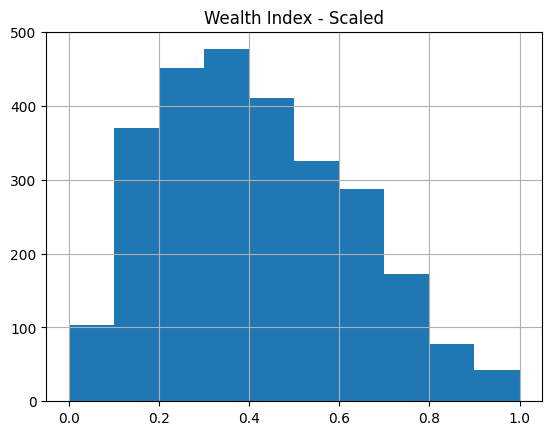

In [56]:
labels.hist()

# Save training data and column metadata

In [57]:
data_gdf = pd.concat([dhs_gdf, unscaled_features, features, labels], axis=1)
data_gdf.to_csv(f"{ROLLOUT_DATE}-training-data.csv", index=False)

In [58]:
feature_cols = features.columns.tolist()
metadata_cols = [
    col for col in data_gdf if col not in feature_cols and col != OUTPUT_LABEL_COL
]

metadata = {
    "features": feature_cols,
    "label": OUTPUT_LABEL_COL,
    "metadata": metadata_cols,
    "unscaled_features": unscaled_features.columns.tolist(),
}

filepath = f"{ROLLOUT_DATE}-training-data-columns.json"
with open(filepath, "w") as file:
    json.dump(metadata, file, indent=4)